In [89]:
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
with open("data.pkl", "rb") as data:
    w2v = pickle.load(data)

In [3]:
## Cosine similarity between earliest and latest embedding
cos_sims = []
for i, w in enumerate(w2v['w']):
    cos_sims.append(cosine_similarity(np.reshape(w2v['E'][i][0], (1,-1)), np.reshape(w2v['E'][i][len(w2v['E'][i])-1], (1,-1)))[0][0])

In [31]:
## Compare overlap of nearest neighbours from earliest to latest year
overlaps = []
old_sims = cosine_similarity(np.array(w2v['E'])[:,0,:], np.array(w2v['E'])[:,0,:])
new_sims = cosine_similarity(np.array(w2v['E'])[:,len(w2v['E'][0])-1,:], np.array(w2v['E'])[:,len(w2v['E'][0])-1,:])
for i, w in enumerate(w2v['w']):
    old_nbrs = np.array(w2v['w'])[np.argsort(old_sims[i])[-20:]]
    new_nbrs = np.array(w2v['w'])[np.argsort(new_sims[i])[-20:]]
    overlaps.append(np.sum(old_nbrs == new_nbrs))

In [137]:
sims_to_topic = []
for i, w in enumerate(w2v['w']):
    old_nbrs_embs = np.array(w2v['E'])[np.argsort(old_sims[i])[-20:], 0]
    avg_old_nbrs = np.mean(old_nbrs_embs, axis=0)
    sim_to_old_topic = cosine_similarity(np.reshape(w2v['E'][i][0], (1,-1)), np.reshape(avg_old_nbrs, (1,-1)))[0][0]
    
    new_old_nbrs_embs = np.array(w2v['E'])[np.argsort(old_sims[i])[-20:], len(w2v['E'][0])-1]
    new_avg_old_nbrs = np.mean(new_old_nbrs_embs, axis=0)
    new_sim_to_old_topic = cosine_similarity(np.reshape(w2v['E'][i][len(w2v['E'][0])-1], (1,-1)), np.reshape(new_avg_old_nbrs, (1,-1)))[0][0]
    sims_to_topic.append(1-(sim_to_old_topic - new_sim_to_old_topic))

In [138]:
print(pearsonr(overlaps, cos_sims))
print(pearsonr(cos_sims, overlaps))
print(pearsonr(overlaps, sims_to_topic))
print(pearsonr(sims_to_topic, cos_sims))

(0.27449332024995216, 6.659337286242944e-36)
(0.27449332024995216, 6.659337286242944e-36)
(0.24018256927889509, 1.2253201159542409e-27)
(0.4092706524261357, 1.262051383745334e-81)


In [139]:
top_1 = np.array(w2v['w'])[np.argsort(cos_sims)[:20]]
top_2 = np.array(w2v['w'])[np.argsort(overlaps)[:20]]
top_3 = np.array(w2v['w'])[np.argsort(sims_to_topic)[:20]]

least_1 = np.array(w2v['w'])[np.argsort(cos_sims)[-20:]]
least_2 = np.array(w2v['w'])[np.argsort(overlaps)[-20:]]
least_3 = np.array(w2v['w'])[np.argsort(sims_to_topic)[-20:]]

In [140]:
print(top_3, least_3)

['approach' 'radio' 'impact' 'assessment' 'objectives' 'film' 'computer'
 'signal' 'center' 'framework' 'sector' 'traffic' 'box' 'interview'
 'basis' 'focus' 'mechanism' 'enterprise' 'mode' 'bit'] ['techniques' 'father' 'implications' 'desires' 'chief' 'fathers'
 'decline' 'commission' 'court' 'shoulders' 'payments' 'goals' 'breach'
 'sunday' 'engineering' 'parents' 'stories' 'david' 'march' 'provisions']


In [100]:
gain_counts = {}
with open("sense_gain_counts.txt", "r") as file:
    lines = file.readlines()
    for l in lines:
        word, count = l.split(" ")
        gain_counts[word] = int(count)

In [141]:
counts = [v for k,v in gain_counts.items() if k in w2v['w']]
# print(len(counts))
print(pearsonr(np.array(cos_sims)[[i for i, w in enumerate(w2v['w']) if w in gain_counts.keys()]], [v for k,v in gain_counts.items() if k in w2v['w']]))
print(pearsonr(np.array(overlaps)[[i for i, w in enumerate(w2v['w']) if w in gain_counts.keys()]], [v for k,v in gain_counts.items() if k in w2v['w']]))
print(pearsonr(np.array(sims_to_topic)[[i for i, w in enumerate(w2v['w']) if w in gain_counts.keys()]], [v for k,v in gain_counts.items() if k in w2v['w']]))

(0.1063580094066486, 0.3844060764405467)
(0.1305061507665868, 0.28514171881213757)
(-0.02133786487558053, 0.861843993612474)


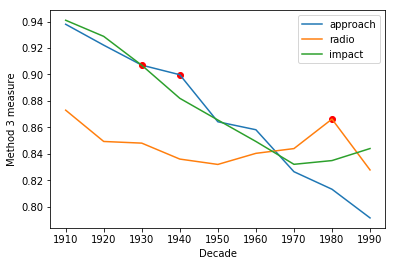

In [160]:
for w in [w2v['w'].index(t) for t in ['approach', 'radio', 'impact']]:
    data = []
    old_nbrs_embs = np.array(w2v['E'])[np.argsort(old_sims[w])[-20:], 0]
    avg_old_nbrs = np.mean(old_nbrs_embs, axis=0)
    sim_to_old_topic = cosine_similarity(np.reshape(w2v['E'][w][0], (1,-1)), np.reshape(avg_old_nbrs, (1,-1)))[0][0]
    for y, d in enumerate(w2v['d']):
        new_old_nbrs_embs = np.array(w2v['E'])[np.argsort(old_sims[w])[-20:], y]
        new_avg_old_nbrs = np.mean(new_old_nbrs_embs, axis=0)
        new_sim_to_old_topic = cosine_similarity(np.reshape(w2v['E'][w][0], (1,-1)), np.reshape(new_avg_old_nbrs, (1,-1)))[0][0]
        
        data.append(1-(sim_to_old_topic - new_sim_to_old_topic))
    data = data[1:]
    changes = np.array([abs(data[i] - data[i+1]) for i in range(0, len(data)-1)])
    changepoint = np.argsort(changes)[len(changes)-1]
    
    plt.plot(changepoint, data[changepoint], 'ro')
    plt.plot(data, label=w2v['w'][w])
    plt.xticks([i for i in range(0,9)], w2v['d'][1:])
    plt.ylabel("Method 3 measure")
    plt.xlabel("Decade")
    plt.legend()